In [1]:
import psycopg2 as pg2
import pandas as pd
from datetime import datetime
import BuildModel
from sklearn.ensemble import RandomForestClassifier
import numpy as np
#from keras.models import Sequential
#from keras.layers import Dense
#from keras.wrappers.scikit_learn import KerasClassifier
import BuildModel
import importlib
from matplotlib import pyplot as plt
from PrevInfo import PrevInfo
from datetime import date, timedelta
plt.style.use('seaborn')

Using TensorFlow backend.


In [2]:
def get_list_of_dates():

    sdate = datetime(2020, 6, 7)   # start date
    edate = datetime(2020, 6, 8)   # end date

    delta = edate - sdate       # as timedelta

    return [sdate + timedelta(days=i) for i in range(delta.days + 1)]
        

In [3]:
def get_actual_and_potential_profits(Xin, yin):
    potential_profits =  (Xin.cashvalue - Xin.fee - Xin.bid/100) -.4
    actual_profits = yin * (Xin.cashvalue - Xin.fee - Xin.bid/100) -.4
    return potential_profits, actual_profits

In [4]:
print ("Connecting to SQL")
conn = pg2.connect(user='postgres',  dbname='penny', host='localhost', port='5432', password='password')

print ("Reading Dataset")

#(select distinct auctionid from auction_full where is_bidomatic

df = pd.read_sql ("""Select *  from auction_full where auctiontime >= '2020-03-01'  and auctionid in (select distinct auctionid from auction_full where is_bidomatic) """, conn)

print ("Splitting into Train/Test Sets")
df = df.sort_values("auctiontime")

Connecting to SQL
Reading Dataset
Splitting into Train/Test Sets


In [5]:
X = df
y = df['is_winner']

In [6]:
df

,auctionid,is_winner,cardtype,cashvalue,cardvalue,fee,bidvalue,limited_allowed,is_locked,auctiontime,...,bom_streak3,perc_to_bin3,prev_is_new_user3,prev_auction_count3,prev_overbid3,prev_giveup_one3,prev_give_before_six3,prev_wins3,prev_bids3,prev_bom_bids3
168931,717265767,False,Shell,37,25,1.0,30,False,False,2020-03-01 00:03:40,...,0.0,0.010811,0.0,20.0,0.05,0.25,0.3,0.25,25.1,21.55
168910,717265767,False,Shell,37,25,1.0,30,False,False,2020-03-01 00:03:40,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
168909,717265767,False,Shell,37,25,1.0,30,False,False,2020-03-01 00:03:40,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
168933,717265767,False,Shell,37,25,1.0,30,False,False,2020-03-01 00:03:40,...,0.0,0.010811,0.0,20.0,0.05,0.25,0.3,0.25,25.1,21.55
168934,717265767,False,Shell,37,25,1.0,30,False,False,2020-03-01 00:03:40,...,0.0,0.010811,0.0,20.0,0.05,0.25,0.3,0.25,25.1,21.55
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7097676,106474640,False,None,6,0,0.0,15,True,False,2020-06-23 16:32:03,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7097675,106474640,False,None,6,0,0.0,15,True,False,2020-06-23 16:32:03,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7097674,106474640,False,None,6,0,0.0,15,True,False,2020-06-23 16:32:03,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
32206,106474640,False,None,6,0,0.0,15,True,False,2020-06-23 16:32:03,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
importlib.reload(BuildModel)
print ("Fitting Model")
#def create_model():
    # Define a Keras model
#    model = Sequential()

#    # Add a Dense layer that uses the sigmoid function
#    model.add(Dense(units=30, kernel_initializer='random_uniform',
#                bias_initializer='zeros', activation='relu', input_dim=74))
#    model.add(Dense(units=30, kernel_initializer='random_uniform',
#                bias_initializer='zeros',  activation='relu'))
#    model.add(Dense(units=1, activation='sigmoid'))
#    
#    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
#    return model

#clf = KerasClassifier(build_fn=create_model,epochs=5,batch_size=10)

model = RandomForestClassifier(n_estimators=200, n_jobs=-1)
#model = clf

pm = BuildModel.PennyModel(model, sampling_ratio=.5 )

Fitting Model


In [8]:
train_cut_off  = datetime(2020, 6, 10) 
test_cut_off = datetime(2020, 6, 25)
profits = []
dates = get_list_of_dates()
#sdate = datetime(2020, 3, 18)   # start date
#edate = datetime(2020, 3, 19)   # end date
#dates = [sdate, edate]
for i in range(1, 2): #len(dates)):
#   train_cut_off = dates[i-1]
#    test_cut_off = dates[i]
    print(train_cut_off, test_cut_off)
    X_train = X[X.auctiontime <= train_cut_off]
    y_train = y[X.auctiontime <= train_cut_off]

    X_test = X[(X.auctiontime > train_cut_off)&(X.auctiontime <= test_cut_off)]
    y_test = y[(X.auctiontime > train_cut_off)&(X.auctiontime <= test_cut_off)]

    X_holdout = X[X.auctiontime > test_cut_off]
    y_holdout = y[X.auctiontime > test_cut_off]

    pm.fit_transform(X_train, y_train)
    print(pm.get_score(X_test, y_test))
    cprobs = pm.predict_proba_calibrated(X_test)[:,1]
    pp, ap = get_actual_and_potential_profits(X_test,y_test)
    expected_value = np.multiply(cprobs, pp) -  (1-cprobs)*.4
 #   profits.append(
#    (sum(ap[expected_value>0]), X_test.shape[0], sum(expected_value>0), sum((ap > 0) & (expected_value >0)), 
#    sum((ap > 0) & (expected_value < 0)), sum((ap < 0)&(expected_value > 0)), sum((ap < 0)&(expected_value < 0))))

    
    # (3450.019999999662, 66260, 6801, 136, 248, 6665, 59211),

2020-06-10 00:00:00 2020-06-25 00:00:00


/home/ubuntu/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/home/ubuntu/PennyAuction/src/BuildModel.py:105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["fee"]=[0 if x == 0 else (1 if x < 50 else 1.99) for x in X["cardvalue"]]
/home/ubuntu/PennyAuction/src/BuildModel.py:106: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

4. Fitting model
26398.359999965734


In [9]:
X_test["ep"] = expected_value
X_test["ap"] = ap


/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [43]:

for i in np.arange(-.5,10, .1):
    test = X_test[(X_test.is_bidomatic)&(X_test.ep>i) & (X_test.ep<=i+.1)]
    print(round(i, 1), len(test), round(np.mean(test.ap),2), np.mean(test.is_winner)*len(test), round(np.mean(test.is_winner), 2))

-0.5 317 -0.4 0.0 0.0
-0.4 321472 -0.36 400.0 0.0
-0.3 216449 -0.28 862.0 0.0
-0.2 94832 -0.18 611.0 0.01
-0.1 44686 -0.04 423.0 0.01
-0.0 23817 0.16 303.0 0.01
0.1 13238 0.26 199.0 0.02
0.2 8175 0.44 150.0 0.02
0.3 5214 0.44 93.0 0.02
0.4 3209 0.66 74.0 0.02
0.5 2231 0.83 59.0 0.03
0.6 1540 0.64 37.0 0.02
0.7 1185 1.3 42.0 0.04
0.8 830 1.37 35.0 0.04
0.9 671 1.0 22.0 0.03
1.0 500 1.43 21.0 0.04
1.1 387 1.24 16.0 0.04
1.2 335 1.77 15.0 0.04
1.3 259 1.4 7.0 0.03
1.4 182 1.98 7.0 0.04
1.5 152 2.53 8.0 0.05
1.6 182 0.88 6.0 0.03
1.7 109 1.69 4.0 0.04
1.8 96 1.44 4.0 0.04
1.9 115 2.83 6.0 0.05
2.0 63 3.94 5.0 0.08
2.1 77 2.45 3.0 0.04
2.2 70 4.87 6.0 0.09
2.3 43 1.69 4.0 0.09
2.4 57 3.63 4.0 0.07
2.5 22 2.32 1.0 0.05
2.6 45 2.0 3.0 0.07
2.7 20 0.6 1.0 0.05
2.8 28 -0.4 0.0 0.0
2.9 13 7.28 1.0 0.08
3.0 24 5.26 2.0 0.08
3.1 25 2.15 2.0 0.08
3.2 14 9.31 2.0 0.14
3.3 3 -0.4 0.0 0.0
3.4 11 2.51 1.0 0.09
3.5 8 4.1 1.0 0.12
3.6 6 -0.4 0.0 0.0
3.7 12 4.77 1.0 0.08
3.8 3 -0.4 0.0 0.0
3.9 9 -0.4 0.0 

In [82]:
i= 1.9
test  = X_test[(X_test.is_bidomatic)&(X_test.ep>.5)]
print(round(i, 1), len(test), round(np.sum(test.ap),2), np.mean(test.is_winner)*len(test), round(np.mean(test.is_winner), 2))

1.9 9424 11711.52 330.0 0.04


In [76]:
test.groupby(["cardtype", "cardvalue", "bidvalue"]).sum().ap

cardtype    cardvalue  bidvalue
Amazon      25         20           654.86
                       30          1041.02
            50         20            87.63
                       30          1502.48
                       35           506.07
            75         10            -2.80
                       20            -4.80
                       30           210.49
            100        30           267.68
            150        30           135.07
Buster      15         15             4.77
                       20            57.07
                       25            19.15
                       30           -11.60
                       35            25.06
            30         0             -2.80
                       15            53.43
                       20            63.55
                       25            71.83
                       30            27.34
Home Depot  25         20            27.85
                       30           212.39
None        0         

In [101]:

for i in range (1000):
    tdf = X_test[(X_test.ep > 0) & (X_test.bid==i)].groupby("bid").sum().head(100)[["is_winner", "ep","ap"]]


In [63]:
aps
#fig, ax = plt.subplots()
#ax.plot(aps, eps)

[Series([], Name: ap, dtype: float64),
 bid
 1    36.78
 Name: ap, dtype: float64,
 bid
 2    884.69
 Name: ap, dtype: float64,
 bid
 3    1022.92
 Name: ap, dtype: float64,
 bid
 4    1251.9
 Name: ap, dtype: float64,
 bid
 5    818.17
 Name: ap, dtype: float64,
 bid
 6    978.23
 Name: ap, dtype: float64,
 bid
 7    617.69
 Name: ap, dtype: float64,
 bid
 8    290.7
 Name: ap, dtype: float64,
 bid
 9    449.26
 Name: ap, dtype: float64,
 bid
 10    185.31
 Name: ap, dtype: float64,
 bid
 11    621.32
 Name: ap, dtype: float64,
 bid
 12    450.54
 Name: ap, dtype: float64,
 bid
 13    321.29
 Name: ap, dtype: float64,
 bid
 14    152.34
 Name: ap, dtype: float64,
 bid
 15    504.85
 Name: ap, dtype: float64,
 bid
 16    162.75
 Name: ap, dtype: float64,
 bid
 17    179.97
 Name: ap, dtype: float64,
 bid
 18    21.3
 Name: ap, dtype: float64,
 bid
 19    146.1
 Name: ap, dtype: float64,
 bid
 20    447.26
 Name: ap, dtype: float64,
 bid
 21    237.53
 Name: ap, dtype: float64,
 bid
 22

(array([2.7923e+04, 6.1910e+03, 2.1620e+03, 8.6900e+02, 4.4500e+02,
        2.5800e+02, 1.8900e+02, 7.2000e+01, 7.0000e+01, 8.8000e+01,
        5.3000e+01, 1.9000e+01, 2.4000e+01, 7.0000e+00, 0.0000e+00,
        1.6000e+01, 1.3000e+01, 2.0000e+01, 1.6000e+01, 0.0000e+00,
        1.2000e+01, 1.0000e+00, 2.0000e+00, 2.3000e+01, 2.0000e+00,
        0.0000e+00, 5.0000e+00, 5.0000e+00, 0.0000e+00, 4.0000e+00,
        0.0000e+00, 0.0000e+00, 4.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 9.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.8000e+01,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 9.0000e+00,
        0.0000e+00, 3.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 1.7000e+01, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.00

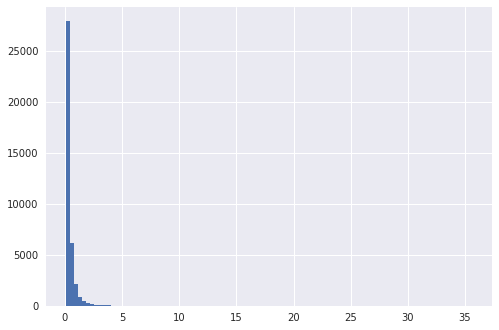

In [142]:
fig, ax = plt.subplots()
plt.hist(df_should_bet.ep[df_should_bet.ep > 0.1], bins=100)

In [159]:
for i in range(0,60000,1000):
    lep = sorted(df_should_bet.ep)[i]
    hep = sorted(df_should_bet.ep)[i+1000]
    print(lep, hep, sum(X_test.ap[(X_test.ep >= lep) & (X_test.ep < hep)]))

2.9734483384391552e-06 0.0033850141094034503 -148.4300000000008
0.0033850141094034503 0.0071608808305811955 -25.660000000003137
0.0071608808305811955 0.010973473256563393 162.03999999999846
0.010973473256563393 0.014935152864797852 125.31999999999763
0.014935152864797852 0.01853577812077417 244.61999999999793
0.01853577812077417 0.022646059319191725 22.18999999999913
0.022646059319191725 0.02673609152611578 -75.22999999999972
0.02673609152611578 0.030663882177828616 153.5699999999999
0.030663882177828616 0.03492864552070363 244.16999999999985
0.03492864552070363 0.039226138916604814 32.45999999999602
0.039226138916604814 0.04404716990798174 355.08000000001635
0.04404716990798174 0.048658111427912765 57.089999999996735
0.048658111427912765 0.05347059160455403 71.35000000000004
0.05347059160455403 0.058637224339830485 124.49999999999505
0.058637224339830485 0.0634597287242128 207.44999999999598
0.0634597287242128 0.06855385247184459 300.7500000000006
0.06855385247184459 0.074046872138361

In [25]:
df.columns

Index(['auctionid', 'is_winner', 'cardtype', 'cashvalue', 'cardvalue', 'fee',
       'bidvalue', 'limited_allowed', 'is_locked', 'auctiontime', 'bid',
       'is_bidomatic', 'bids_so_far', 'username', 'prevusers', 'giveup',
       'eventual_bids', 'eventual_win_price', 'debut', 'bom_streak',
       'bom_bids_so_far', 'perc_to_bin', 'username0', 'distance0',
       'is_bidomatic0', 'bids_so_far0', 'bom_bids_so_far0', 'bom_streak0',
       'perc_to_bin0', 'prev_is_new_user0', 'prev_auction_count0',
       'prev_overbid0', 'prev_giveup_one0', 'prev_give_before_six0',
       'prev_wins0', 'prev_bids0', 'prev_bom_bids0', 'username1', 'distance1',
       'is_bidomatic1', 'bids_so_far1', 'bom_bids_so_far1', 'bom_streak1',
       'perc_to_bin1', 'prev_is_new_user1', 'prev_auction_count1',
       'prev_overbid1', 'prev_giveup_one1', 'prev_give_before_six1',
       'prev_wins1', 'prev_bids1', 'prev_bom_bids1', 'username2', 'distance2',
       'is_bidomatic2', 'bids_so_far2', 'bom_bids_so_far2', 

In [24]:
df.groupby('auctiontime').mean().limited_allowed

auctiontime
2020-05-01 00:01:46    0.0
2020-05-01 00:02:30    0.0
2020-05-01 00:02:43    0.0
2020-05-01 00:10:32    0.0
2020-05-01 00:19:25    0.0
                      ... 
2020-06-23 16:11:22    1.0
2020-06-23 16:16:39    1.0
2020-06-23 16:16:42    0.0
2020-06-23 16:27:26    1.0
2020-06-23 16:32:03    1.0
Name: limited_allowed, Length: 17021, dtype: float64

In [34]:
X_test["ep"] = expected_value
X_test["ap"] = ap

/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [212]:
np.mean(X_train.limited_allowed)

0.08270028708510672

In [104]:
df_should_bet.groupby(["bid"]).sum().head(100).tail(50)["ap"]

bid
51      50.88
52      96.34
53      51.88
54      34.93
55      56.50
56      10.08
57     -40.57
58     124.31
59      33.83
60     -54.40
61      90.99
62     159.93
63       6.74
64     -46.40
65       4.30
66     149.91
67     175.73
68      42.25
69      39.43
70     -46.00
71     -18.31
72     126.24
73     -54.40
74     119.05
75      50.91
76      51.29
77     -48.00
78     125.26
79     -12.39
80     -38.80
81      15.98
82     122.74
83       9.98
84      -2.04
85      53.91
86      19.15
87      37.07
88     -37.60
89     174.55
90     147.31
91     -36.40
92     101.26
93      -3.33
94     -33.60
95      -4.55
96     -31.20
97      27.67
98     -35.20
99       4.21
100    -30.00
Name: ap, dtype: float64

In [206]:
df_should_bet.groupby(["cardtype", "cardvalue", "bidvalue", "limited_allowed"]).mean().loc[:,["ep","ap"]]

ep        ap
cardtype   cardvalue bidvalue limited_allowed                    
Amazon     25        20       False            0.364436  0.453328
                     30       False            0.516037  0.461227
           50        20       False            0.250088 -0.165243
                     30       False            0.333159  0.427836
                     35       False            0.277083  0.559378
           75        30       False            0.181680 -0.026610
           100       30       False            0.273632 -0.173746
           150       30       False            0.328690 -0.027397
Buster     15        0        False            0.177041 -0.400000
                     15       False            0.189350  0.630517
                     20       False            0.570353  0.356118
                     25       False            0.236937  1.483600
                     30       False            0.454611  0.680213
           30        0        False            0.100691  0.697333
                     15       False            0.343471  1.715877
                     20       False            0.249503  1.269083
                     25       False            0.248688  2.244655
                     30       False            0.136844  0.866355
Home Depot 25        20       False            0.497587  1.511538
                     30       False            1.611611  0.958546
None       0         15       False            0.689714  0.026333
                     25       False            0.420119  0.136749
                     50       False            0.334526  0.221589
                     100      False            0.231152  0.443677
                     250      False            0.277890  0.247680
Shell      25        20       False            0.255316  0.244497
                     30       False            0.321789  0.361117
           50        20       False            0.189771 -0.084543
                     30       False            0.247624  0.409256
                     35       False            0.234318  0.332191
Target     25        20       False            0.382915  0.613841
                     30       False            0.712451  0.440324
Walmart    25        20       False            0.273940  0.409246
                     30       False            0.353451  0.198794
           50        20       False            0.281281  1.130290
                     30       False            0.287698  0.224264
                     35       False            0.237974  0.158579

In [70]:
df_should_bet.groupby("bid").mean().loc[:,["ep","ap"]].head(30)

,ep,ap
bid,,
1,2.799013,0.253572
2,0.494133,-0.044472
3,0.655939,0.731016
4,0.465135,0.393511
5,0.512505,0.922892
6,0.453926,0.360440
7,0.446636,0.174626
8,0.466881,0.462852
9,0.469754,0.623035


In [23]:
df_should_bet["hour"] = [x.hour for x in df_should_bet.auctiontime]

/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [25]:
df_should_bet.groupby("hour").mean()

,auctionid,is_winner,cashvalue,cardvalue,fee,bidvalue,limited_allowed,is_locked,bid,is_bidomatic,...,prev_is_new_user3,prev_auction_count3,prev_overbid3,prev_giveup_one3,prev_give_before_six3,prev_wins3,prev_bids3,prev_bom_bids3,ep,ap
hour,,,,,,,,,,,,,,,,,,,,,
0,4.469113e+08,0.011864,58.361345,38.044983,1.405986,50.790905,0.266436,0.422145,517.345526,0.734553,...,0.005409,449.432049,0.078807,0.204969,0.429037,0.154530,37.882795,28.975760,0.220688,0.061888
1,4.433931e+08,0.010290,68.057530,25.619738,1.016338,106.094481,0.152947,0.233396,340.542095,0.829280,...,0.001376,720.431912,0.064284,0.237605,0.461514,0.133556,27.693507,18.511483,0.382452,0.036197
2,4.632456e+08,0.013067,72.312242,15.845942,0.640454,141.165750,0.104539,0.229023,361.870702,0.781293,...,0.000000,604.750816,0.053595,0.203069,0.429246,0.144841,29.172176,20.012066,0.526368,0.140420
3,5.608969e+08,0.013021,42.033854,31.992188,1.280339,25.104167,0.367188,0.320312,403.348958,0.867188,...,0.014981,853.397004,0.062318,0.211910,0.465489,0.084918,22.919833,15.810571,0.733856,-0.082812
4,6.828974e+08,0.010840,44.737127,32.113821,1.281653,31.558266,0.000000,0.105691,118.888889,0.804878,...,0.055556,970.736111,0.062723,0.210998,0.482541,0.124567,23.671923,15.667287,0.230818,-0.023550
5,3.781619e+08,0.013011,53.163569,41.356877,1.647621,29.516729,0.011152,0.089219,236.046468,0.832714,...,0.000000,502.625352,0.053122,0.229686,0.498188,0.131720,26.482812,18.105176,0.398100,0.068290
6,4.941750e+08,0.058065,35.000000,24.677419,0.987097,25.806452,0.000000,0.038710,47.335484,0.800000,...,0.000000,990.490566,0.073741,0.199420,0.553930,0.128440,21.439487,13.411872,0.533005,1.548903
7,4.874548e+08,0.035587,36.608541,20.907473,0.835374,39.252669,0.028470,0.067616,77.195730,0.765125,...,0.007246,792.260870,0.068918,0.172079,0.484393,0.113442,23.795686,17.154430,0.412432,0.890498
8,4.642811e+08,0.032885,54.727952,19.334828,0.788490,88.482810,0.239163,0.010463,61.064275,0.742900,...,0.003135,714.250784,0.073217,0.209076,0.503419,0.117166,26.743611,17.862901,0.531149,1.128580


In [26]:
df_should_bet["day"] = [x.day for x in df_should_bet.auctiontime]

/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [69]:
df_should_bet[df_should_bet.cardtype.isin(["Buster"])].groupby(["is_winner"]).sum()

,auctionid,cashvalue,cardvalue,fee,bidvalue,limited_allowed,is_locked,bid,is_bidomatic,bids_so_far,...,prev_overbid3,prev_giveup_one3,prev_give_before_six3,prev_wins3,prev_bids3,prev_bom_bids3,ep,ap,hour,day
is_winner,,,,,,,,,,,,,,,,,,,,,
False,348635535546,21665,16065,673.0,14000,96.0,127.0,101407,496.0,20849,...,31.738910,41.590641,69.487109,53.776708,15352.345385,10325.032192,184.366058,-269.20,9387,10164
True,15327871055,769,555,24.0,535,4.0,3.0,3219,24.0,689,...,0.828481,1.803709,3.261990,1.663795,485.184993,318.767422,8.737513,703.21,376,361


378
5719
31184


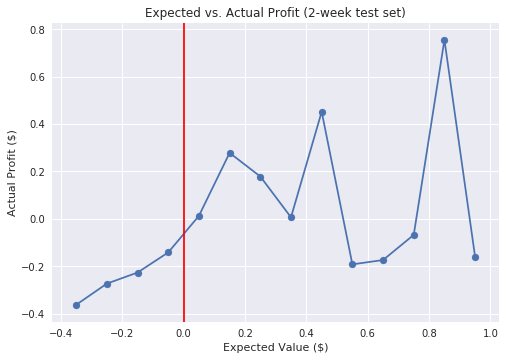

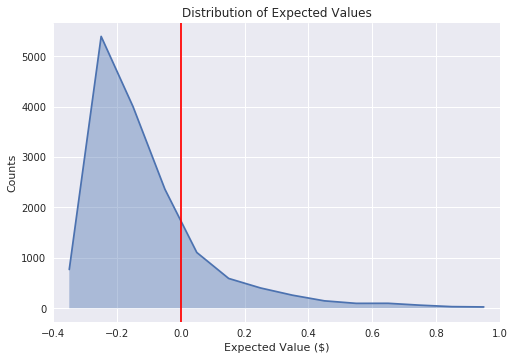

In [37]:
exs = []
acs = []
counts = []
bin_size=.1
for i in np.arange (-1, 1, bin_size):
    my_profit = ap[(expected_value > i)&(expected_value < i + bin_size/2)]
    num_bids = my_profit.shape[0]
    if (num_bids > 0):
        exs.append (i + bin_size/2)
        acs.append (sum(my_profit)/num_bids)
        counts.append(num_bids)
fig, ax = plt.subplots()
ax.plot(exs, acs)
ax.scatter(exs, acs)
ax.set_xlabel("Expected Value ($)")
ax.set_ylabel("Actual Profit ($)")
ax.set_title("Expected vs. Actual Profit (2-week test set)")
ax.axvline(x=0, color="red")

fig, ax = plt.subplots()
ax.plot(exs, counts)
ax.set_xlim(left=-.4, right=1)
ax.axvline(x=0, color="red")
ax.fill_between(exs, 0, counts, alpha=.4)
ax.set_xlabel("Expected Value ($)")
ax.set_ylabel("Counts")
ax.set_title("Distribution of Expected Values")
print(sum((ap > 0) & (expected_value >0)))
print(sum(expected_value > 0))
print(len(expected_value))

In [167]:
profit_sum = 0
bets_sum = 0
for b in buckets:
    bets_sum += b[2]
    profit_sum += b[1]
print(bets_sum, profit_sum, profit_sum/bets_sum)

NameError: name 'buckets' is not defined

In [345]:
pm.pickle(filename="rf.pkl")

5. Pickling model as penny_auction.pickle


2. Transforming data


31476.382150766545

2. Transforming data


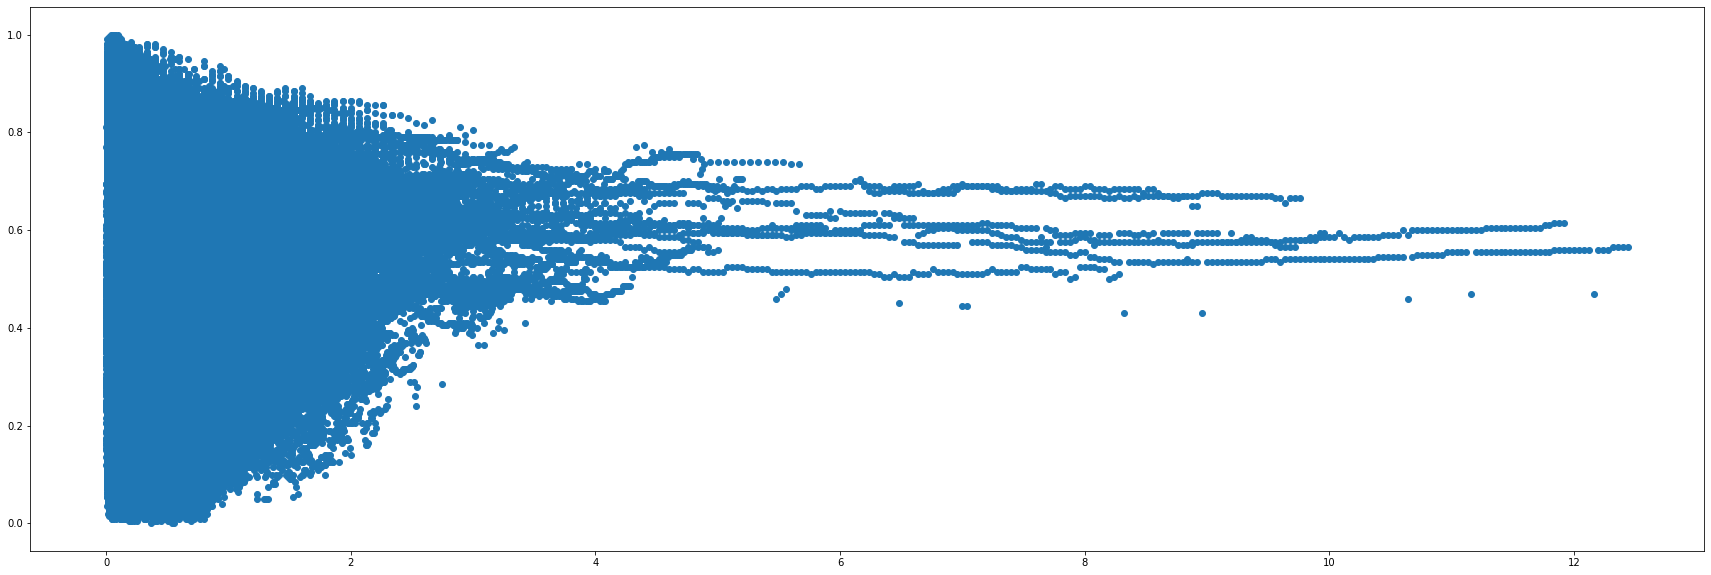

In [89]:
f = "perc_to_bin0"
amazon_50_30 = X_test  #[(X_test.cardtype=="Amazon")&(X_test.bidvalue==100)&(X_test.cardvalue==0)]
test_df = amazon_50_30.sort_values(f)
preds = pm.predict_proba(test_df)[:,1]
preds
fig, ax = plt.subplots(figsize=(30, 10))
ax.scatter(test_df[f], preds)

# Random Forest:   26,480/25,802

2. Transforming data
-12.889999999999981
12677 167
****************
116.55000000000005
31997 1063
****************
796.9400000000511
64775 2711
****************
10233.650000004822
241665 25121
****************
8841.890000006097
277041 31694
****************
3729.1299999994367
87788 11464
****************
222.17000000000255
25397 360
****************
23927.44000001041


In [348]:
pi = PrevInfo()
pi.pickle ("pi.pkl")

Connecting to SQL


In [83]:
buckets

[((0, 5.7, 0.98),
  17.000000000000195,
  array([False, False, False, ..., False, False, False])),
 ((5.7, 9.7, 0.9),
  133.39999999999512,
  array([False, False, False, ..., False, False, False])),
 ((9.7, 19.7, 0.78),
  1085.3100000000218,
  array([False, False, False, ..., False, False, False])),
 ((19.7, 40, 0.66),
  16661.16000000705,
  array([ True, False,  True, ..., False,  True, False])),
 ((40, 62, 0.52),
  17653.790000007873,
  array([ True, False,  True, ...,  True,  True, False])),
 ((62, 100, 0.48),
  4531.390000000543,
  array([ True, False,  True, ...,  True,  True,  True])),
 ((100, 200, 0.5700000000000001),
  577.9500000000024,
  array([ True, False,  True, ..., False,  True, False]))]

In [472]:
from sklearn.metrics import auc, confusion_matrix, precision_score, recall_score, accuracy_score, roc_curve
def shuffle_column(X, feature_index):
    ''' 
    Parameters
    ----------
    X: numpy array
    feature_index: int
    
    Returns
    -------
    X_new: numpy array
    
    Returns a new array identical to X but
    with all the values in column feature_index
    shuffled
    '''   
    
    X_new = X.copy()
    X_new[feature_index] = np.random.permutation(X_new[feature_index])
    return X_new    

def permutation_importance(model, X_test, y_test, scorer=accuracy_score):
    ''' Calculates permutation feature importance for a fitted model
    
    Parameters
    ----------
    model: anything with a predict() method
    X_test, y_test: numpy arrays of data
        unseen by model
    scorer: function. Should be a "higher is better" scoring function,
        meaning that if you want to use an error metric, you should
        multiply it by -1 first.
        ex: >> neg_mse = lambda y1, y2: -mean_squared_error(y1, y2)
            >> permutation_importance(mod, X, y, scorer=neg_mse)
    
    Returns
    -------
    feat_importances: numpy array of permutation importance
        for each feature
    
    '''
    
    feat_importances = np.zeros(X_test.shape[1])
    test_score = scorer(model.predict(X_test), y_test)
    for i in range(X_test.shape[1]):
        X_test_shuffled = shuffle_column(X_test, X_test.columns[i])
        test_score_permuted = scorer(y_test, model.predict(X_test_shuffled))
        print(test_score, test_score_permuted)
        feat_importances[i] = test_score - test_score_permuted
    return feat_importances

In [473]:
pis = permutation_importance(pm, X_test, y_test)

0.8815941259997121 0.8815941259997121
0.8815941259997121 0.8815941259997121
0.8815941259997121 0.8830581148807005


KeyboardInterrupt: 

In [ ]:
for c, pi in sorted(zip(X_test.columns, pis), key=lambda x: abs(x[1])):
    print(c, pi)
    
key=lambda x: x[1]

Plotting features


Text(0.5, 0, 'Average contribution to information gain')

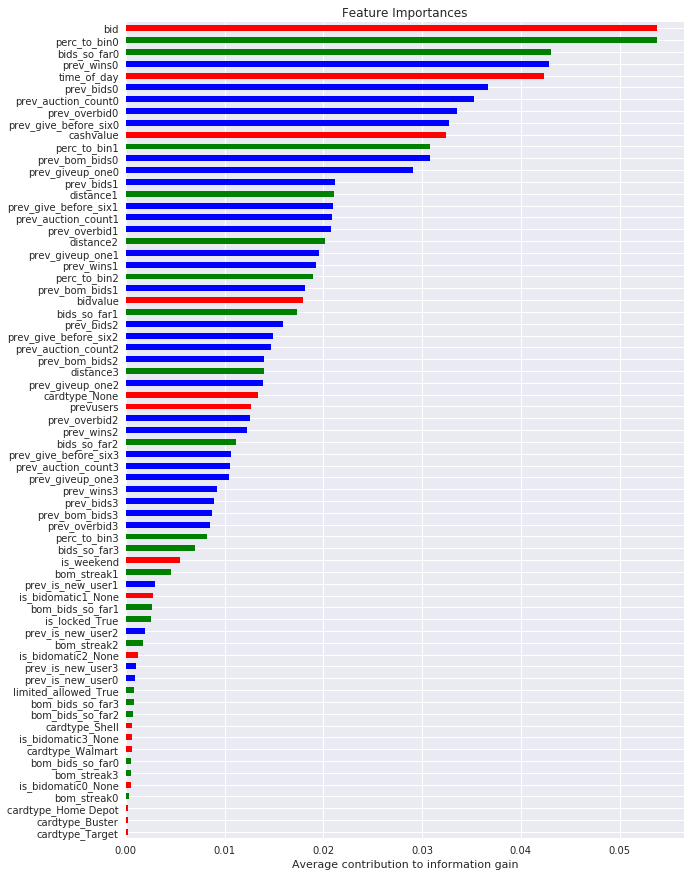

In [38]:

print ("Plotting features")
# Plot the feature importance
feat_scores = pm.get_feature_scores()
feat_scores = feat_scores.sort_values()
colors = []
for fs in feat_scores.iteritems():
    if (fs[0].startswith('prev') and not fs[0]=="prevusers"):
        colors.append("blue")
    elif (fs[0].endswith('0') or fs[0].endswith('1') or fs[0].endswith('2') or fs[0].endswith('3') or fs[0].endswith("_True")):
        colors.append("green")
    else:
        colors.append("red")
fig, ax = plt.subplots()
ax = feat_scores.plot(kind='barh', 
                      figsize=(10,15),
                      color=colors)
ax.set_title('Feature Importances')
ax.set_xlabel('Average contribution to information gain')


In [442]:
feat_scores.iter_items()

AttributeError: 'Series' object has no attribute 'iter_items'

In [459]:
X_test.columns

Index(['auctionid', 'is_winner', 'cardtype', 'cashvalue', 'cardvalue', 'fee',
       'bidvalue', 'limited_allowed', 'is_locked', 'auctiontime', 'bid',
       'is_bidomatic', 'bids_so_far', 'username', 'prevusers', 'giveup',
       'eventual_bids', 'eventual_win_price', 'debut', 'bom_streak',
       'bom_bids_so_far', 'perc_to_bin', 'username0', 'distance0',
       'is_bidomatic0', 'bids_so_far0', 'bom_bids_so_far0', 'bom_streak0',
       'perc_to_bin0', 'prev_is_new_user0', 'prev_auction_count0',
       'prev_overbid0', 'prev_giveup_one0', 'prev_give_before_six0',
       'prev_wins0', 'prev_bids0', 'prev_bom_bids0', 'username1', 'distance1',
       'is_bidomatic1', 'bids_so_far1', 'bom_bids_so_far1', 'bom_streak1',
       'perc_to_bin1', 'prev_is_new_user1', 'prev_auction_count1',
       'prev_overbid1', 'prev_giveup_one1', 'prev_give_before_six1',
       'prev_wins1', 'prev_bids1', 'prev_bom_bids1', 'username2', 'distance2',
       'is_bidomatic2', 'bids_so_far2', 'bom_bids_so_far2', 

In [499]:


# Use the roc_curve method to create false positive rates, true positive rates
fpr, tpr, thresholds = roc_curve(y_test, probs)

# Use these rates to generate an 'area under the curve score', print it
r_auc = auc(fpr, tpr)

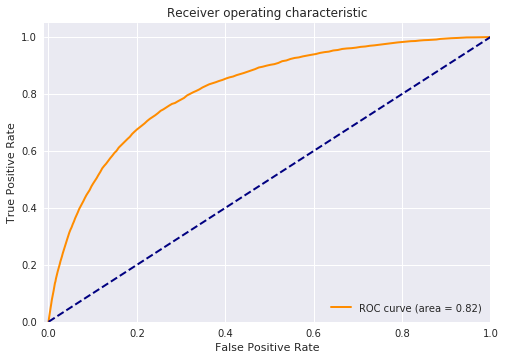

In [501]:
# Plot the ROC curve.
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % r_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()


In [563]:
profits

[(2091.129999999336, 74023, 9059, 134),
 (1877.8399999996818, 56999, 7642, 120),
 (1463.7699999999295, 55473, 6655, 106),
 (3953.879999999448, 67957, 8254, 176),
 (3882.959999999555, 75405, 8066, 165),
 (2320.6899999998986, 55111, 5174, 97),
 (1555.349999999928, 74218, 6275, 95),
 (2249.049999999554, 66393, 8064, 127),
 (1577.5799999997694, 60036, 7196, 120),
 (402.0000000001004, 62701, 6878, 83),
 (2035.859999999706, 55667, 5624, 117),
 (1608.569999999938, 55649, 4622, 86),
 (1903.86999999968, 60730, 6619, 109)]

In [564]:
my_ps = [p[0] for p in profits]

In [565]:
my_ps


[2091.129999999336,
 1877.8399999996818,
 1463.7699999999295,
 3953.879999999448,
 3882.959999999555,
 2320.6899999998986,
 1555.349999999928,
 2249.049999999554,
 1577.5799999997694,
 402.0000000001004,
 2035.859999999706,
 1608.569999999938,
 1903.86999999968]

In [572]:
my_ds = [str(d).split()[0] for d in get_list_of_dates()]

In [573]:
my_ds

['2020-02-15',
 '2020-02-16',
 '2020-02-17',
 '2020-02-18',
 '2020-02-19',
 '2020-02-20',
 '2020-02-21',
 '2020-02-22',
 '2020-02-23',
 '2020-02-24',
 '2020-02-25',
 '2020-02-26',
 '2020-02-27',
 '2020-02-28']

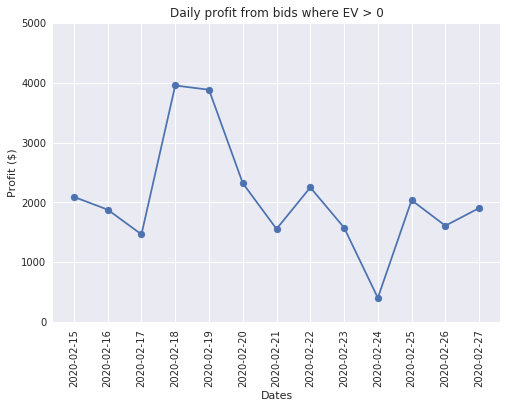

In [595]:
fig, ax =plt.subplots()
ax.scatter(my_ds[:-1], my_ps)
ax.plot(my_ds[:-1], my_ps)
ax.set_ylim(0, 5000)
ax.set_xlabel("Dates")
ax.set_ylabel("Profit ($)")
ax.set_title("Daily profit from bids where EV > 0")
for tick in ax.get_xticklabels():
    tick.set_rotation(90)

In [589]:
profits

[(2091.129999999336, 74023, 9059, 134),
 (1877.8399999996818, 56999, 7642, 120),
 (1463.7699999999295, 55473, 6655, 106),
 (3953.879999999448, 67957, 8254, 176),
 (3882.959999999555, 75405, 8066, 165),
 (2320.6899999998986, 55111, 5174, 97),
 (1555.349999999928, 74218, 6275, 95),
 (2249.049999999554, 66393, 8064, 127),
 (1577.5799999997694, 60036, 7196, 120),
 (402.0000000001004, 62701, 6878, 83),
 (2035.859999999706, 55667, 5624, 117),
 (1608.569999999938, 55649, 4622, 86),
 (1903.86999999968, 60730, 6619, 109)]

In [590]:
sum(ap>0)

316

In [593]:
sum(ap[expected_value > 0])

1903.86999999968

In [14]:
profits


[(2413.7599999996237, 74663, 6785, 118, 266, 6667, 67612),
 (3589.549999999681, 66260, 6553, 138, 246, 6415, 59461),
 (1904.1299999993225, 74023, 9260, 133, 253, 9127, 64510)]

In [17]:
ev

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-17-2cf3baf58f53>", line 1, in <module>
    ev
NameError: name 'ev' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2044, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'NameError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/lib/python3.6/site-packages/IPython/core/ultratb.py", line 1151, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, tb_offset)
  File "/home/ubuntu/anaconda3/lib/python3.6/site-packages/

NameError: name 'ev' is not defined